# On backported updates

In [1]:
import pandas
import numpy as np
import matplotlib
import seaborn

from scipy.stats import mannwhitneyu
from cliffsDelta import cliffsDelta

from IPython.display import display

%matplotlib inline

In [2]:
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (9, 3)

ECOSYSTEMS = ['Cargo', 'npm', 'Packagist', 'Rubygems']
DATE_RANGE = pandas.to_datetime('2015-01-01'), pandas.to_datetime('2020-01-01')
CENSOR_DATE = pandas.to_datetime('2020-01-12')

PALETTE = seaborn.color_palette()
PAL_REL = np.take(seaborn.color_palette('muted'), [3, 8, 2, 0], axis=0)
COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SAVEFIG = True

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

# Datasets

## Load data

In [3]:
df_required = dict()
df_dependents = dict()

for ecosystem in ECOSYSTEMS:
    # We decided to change "NPM" to "npm"
    if ecosystem == 'npm': 
        e = 'NPM'
    else: e = ecosystem
        
    print('Loading', ecosystem)
    print('.. required packages')
    df_required[ecosystem] = (
        pandas.read_csv(
            '../data/{}-required.csv.gz'.format(e),
            parse_dates=['date'],
            infer_datetime_format=True,
        )
    )
    
    print('.. dependent packages')
    df_dependents[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependents.csv.gz'.format(e),
        )
    )
    
print('Done!')

Loading Cargo
.. required packages
.. dependent packages
Loading npm
.. required packages
.. dependent packages
Loading Packagist
.. required packages
.. dependent packages
Loading Rubygems
.. required packages
.. dependent packages
Done!


## Data cleaning

We know there are cases in which many releases of a package are imported at the same time, or in a non-revelant order. 
Such cases are problematic, since the corresponding updates are likely to be wrongly considered as backports. 

To mitigate this, we remove each package:
 - (1) for which the chronological order of its major releases does not follow the version order;
 - (2) for which a release preceedes the release date of its corresponding major.

In [4]:
filter_1 = pandas.concat([
    df_required[ecosystem]
    [lambda d: d['kind'].isin(['major', 'initial'])]
    [['package', 'rank', 'rank_date']]
    .sort_values('rank')
    # (1) and (2)
    .groupby('package', sort=False, as_index=False)
    .agg({
        'rank_date': lambda s: s.rank().is_monotonic,
    })
    .query('not rank_date')
    [['package']]
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'package']]
    for ecosystem in ECOSYSTEMS]
)

In [5]:
(
     filter_1
    .groupby('ecosystem')
    .count()
)

,package
ecosystem,
Cargo,1
Packagist,46
Rubygems,28
npm,183


In [6]:
filter_2 = pandas.concat([
    df_required[ecosystem]
    [lambda d: d['package'].isin(
        df_required[ecosystem]
        .sort_values('rank_date')
        .groupby(['package', 'major'], sort=False, as_index=False)
        .first()
        .query('kind not in ["major", "initial"]')
        .package    
    )]
    [['package']]
    .drop_duplicates()
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'package']]
    for ecosystem in ECOSYSTEMS]
)

In [7]:
(
     filter_2
    .groupby('ecosystem')
    .count()
)

,package
ecosystem,
Cargo,5
Packagist,50
Rubygems,53
npm,197


In [8]:
data = filter_1.append(filter_2)

In [9]:
(
    data
    .groupby('ecosystem')
    .count()
)

,package
ecosystem,
Cargo,6
Packagist,96
Rubygems,81
npm,380


Let's remove these packages, and the related dependents.

In [10]:
for ecosystem in ECOSYSTEMS:
    packages = data[lambda d: d['ecosystem'] == ecosystem].package
    df_required[ecosystem] = df_required[ecosystem][lambda d: ~d['package'].isin(packages)]
    df_dependents[ecosystem] = df_dependents[ecosystem][lambda d: ~d['target'].isin(packages)]

## Data overview

In [11]:
data = pandas.DataFrame(index=['required', 'releases', 'dependents', 'dependencies'], columns=ECOSYSTEMS)

for ecosystem in ECOSYSTEMS:
    data.at['required', ecosystem] = len(df_required[ecosystem].drop_duplicates('package'))
    data.at['releases', ecosystem] = len(df_required[ecosystem])
    data.at['dependents', ecosystem] = len(df_dependents[ecosystem].drop_duplicates('source'))
    data.at['dependencies', ecosystem] = len(df_dependents[ecosystem])
    
data

,Cargo,npm,Packagist,Rubygems
required,1185,15281,2247,652
releases,26185,570676,100870,35264
dependents,13143,242618,35488,7915
dependencies,59814,1021843,89667,15066


In [12]:
data.T[['required', 'releases', 'dependents', 'dependencies']].sum()

required          19365.0
releases         732995.0
dependents       299164.0
dependencies    1186390.0
dtype: float64

Our dependency constraint parsers were able to cope with the large majority of dependency constraints. However, some of them could not be parsed. Let's quantify this by counting the number of empty intervals. Notice that an empty interval could also be the result of a wrongly specified constraint, semantically-wise, so the proportions we report are a kind of upper bound.  

In [13]:
(
    pandas.concat([
        df_dependents[ecosystem]
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS], 
        axis=0
    )
    .pivot_table(index='ecosystem', columns=['c_empty'], values='target', aggfunc='count', margins=True)
    .fillna(0)
    .assign(prop=lambda d: d[True] / d['All'])
    .style
    .format({'prop': '{:.1%}'})
)

c_empty,False,True,All,prop
ecosystem,,,,
Cargo,59814.000000,0.000000,59814,0.0%
Packagist,87640.000000,2027.000000,89667,2.3%
Rubygems,14206.000000,860.000000,15066,5.7%
npm,1017246.000000,4597.000000,1021843,0.4%
All,1178906.000000,7484.000000,1186390,0.6%


# On the need to backport updates to previous major

## Permissivity of dependency constraints

We look at how permissive dependency constraints are, this is, whether they accept patches, minor or major releases. Since we know from previous work that such permissiveness depends on whether the target package is 0.y.z or >=1.0.0, we distinguish these two cases. 

Let's first quantify the number of targets for each category.

In [14]:
pandas.concat([
    df_dependents[ecosystem]
    .groupby('c_dev', as_index=False)
    [['target']]
    .count()
    .assign(prop=lambda d: d['target'] / d['target'].sum())
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS], axis=0
).set_index(['ecosystem', 'c_dev'])

target      prop
ecosystem c_dev                  
Cargo     False   21455  0.358695
          True    38359  0.641305
npm       False  919629  0.899971
          True   102214  0.100029
Packagist False   86410  0.963677
          True     3257  0.036323
Rubygems  False   12555  0.833333
          True     2511  0.166667

In [15]:
data = pandas.concat([
    df_dependents[ecosystem]
    .sort_values('rank')
    .drop_duplicates(['source', 'target'], keep='last')
    .assign(
        n=1,
        # Correct values, as patch superseeded by minor superseeded by major
        patch=lambda d: d['c_patch'] & ~d['c_minor'] & ~d['c_major'],
        minor=lambda d: d['c_minor'] & ~d['c_major'],
        major=lambda d: d['c_major'],
    )
    .pivot_table(index='c_dev', values=['n', 'major', 'minor', 'patch'], aggfunc='sum')
    .apply(lambda s: s / s.n, axis=1)
    .drop(columns=['n'])
    .reset_index()
    .rename(columns={'c_dev': 'kind'})
    .replace({'kind': {True: '0.y.z', False: '>=1.0.0'}})
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
    axis=0
).set_index(['ecosystem', 'kind'])

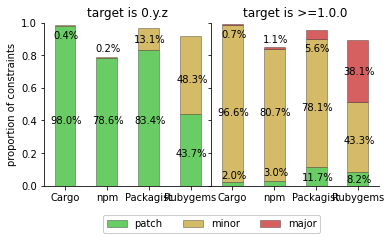

In [16]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=2, 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, kind in enumerate(['0.y.z', '>=1.0.0']):
    (
        data
        .xs(kind, level=1)
        [['patch', 'minor', 'major']]
        .plot.bar(stacked=True, color=PAL_REL[0:3][::-1], linewidth=1, edgecolor=(0, 0, 0, 0.3), legend=False, ax=axes[i])
    )
    
    axes[i].set(
        title='target is {}'.format(kind),
        xlabel='', 
        ylabel=''
    )
    axes[i].xaxis.set_tick_params(rotation=0)

positions = [
    ((0.40, 0.92), (0.06, 0.45, 0.93)),
    ((0.40, 0.84), (0.08, 0.45, 0.90)),
    ((0.40, 0.90), (0.05, 0.48, 0.84)),
    ((0.20, 0.65), (0.04, 0.28, 0.70)),
]
for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, kind in enumerate(['0.y.z', '>=1.0.0']):
        for k, release in enumerate(['patch', 'minor', 'major']):
            value = data.loc[ecosystem, kind][release]
            if kind == '0.y.z' and release == 'major':
                continue
            axes[j].annotate('{:.1%}'.format(value), (i + 0.03, positions[i][j][k]), ha='center', va='center')
    
axes[0].legend(
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(1, -0.32),
)

seaborn.despine(fig, top=True, right=True)

axes[0].set(
    xlabel='',
    ylabel='proportion of constraints',
    ylim=(0, 1),
)

savefig(fig, 'need_permissiveness')

In [17]:
data.T

ecosystem     Cargo                 npm           Packagist            \
kind        >=1.0.0     0.y.z   >=1.0.0     0.y.z   >=1.0.0     0.y.z   
major      0.006991  0.000000  0.010734  0.000000  0.056186  0.000000   
minor      0.965882  0.003598  0.806637  0.001829  0.780512  0.131409   
patch      0.019762  0.980396  0.030481  0.785587  0.116665  0.834203   

ecosystem  Rubygems            
kind        >=1.0.0     0.y.z  
major      0.380725  0.000000  
minor      0.432895  0.482676  
patch      0.081800  0.436878

As expected, most dependencies (except in Rubygems) are "compliant with semver". That means that, in a situation where they make use of the latest major release of a target package, they will automatically benefit from the latest patch (for 0.y.z) and minor releases (for >=1.0.0).

## Releases being used by dependent packages

However, we expect that not all dependents make use of the latest major of a target package. Let's quantify how many dependents make use of: the latest release, a previous patch, a previous minor or a previous major.

In [18]:
data = pandas.concat([
    df_dependents[ecosystem]
    [['source', 'target', 'selected']]
    # Get highest release of target package
    .merge(
        df_required[ecosystem]
        .drop_duplicates('package', keep='last')
        [['package', 'major', 'minor', 'patch']],
        how='inner',
        left_on='target',
        right_on='package',
    )
    # Get release for selected one
    .merge(
        df_required[ecosystem]
        [['package', 'rank', 'major', 'minor', 'patch']],
        how='inner',
        left_on=['target', 'selected'],
        right_on=['package', 'rank'],
        suffixes=(None, '_selected'),
    )
    .drop(columns=['package', 'package_selected', 'rank'])
    # Identify release being used
    .eval('''
        latest = major_selected == major and minor_selected == minor and patch_selected == patch
        previous_major = major_selected < major
        previous_minor = major_selected == major and minor_selected < minor
        previous_patch = major_selected == major and minor_selected == minor and patch_selected < patch
    ''')
    .assign(kind=lambda d: d[['latest', 'previous_major', 'previous_minor', 'previous_patch']].idxmax(axis=1))
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'source', 'target', 'kind', 'major_selected', 'major']]
    for ecosystem in ECOSYSTEMS],
)

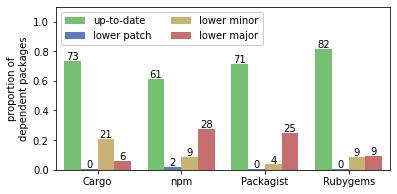

In [19]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .groupby(['ecosystem', 'kind'])
    .agg({'source': 'count'})
    .div(
        data
        .groupby('ecosystem')
        .agg({'source': 'count'})
    )
    .reset_index()
    .replace({'kind': {'latest': 'up-to-date', 'previous_major': 'lower major', 'previous_minor': 'lower minor', 'previous_patch': 'lower patch'}})
)

seaborn.barplot(
    x='ecosystem',
    y='source',
    hue='kind',
    hue_order=['up-to-date', 'lower patch', 'lower minor', 'lower major'],
    order=ECOSYSTEMS,
    data=temp,
    palette=np.take(PAL_REL, [2, 3, 1, 0], axis=0),
    ax=ax
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, label in enumerate(['up-to-date', 'lower patch', 'lower minor', 'lower major']):
        value = temp[lambda d: (d['ecosystem'] == ecosystem) & (d['kind'] == label)].iloc[0].source
        x = i + (j * 0.2 - 0.30)
        ax.annotate('{:.0f}'.format(value * 100), (x, value + 0.03), ha='center', va='center')

ax.legend(ncol=2, loc='upper left')

ax.set(
    xlabel='',
    ylabel='proportion of\ndependent packages',
    ylim=(0, 1.1),
)

savefig(fig, 'need_used_release')

In [20]:
(
    pandas.crosstab(data['ecosystem'], data['kind'], normalize='index', margins=True)
    .style.format('{:.1%}').background_gradient(vmin=0, vmax=1)
)

kind,latest,previous_major,previous_minor,previous_patch
ecosystem,,,,
Cargo,73.4%,5.7%,20.6%,0.3%
Packagist,71.4%,24.6%,3.6%,0.4%
Rubygems,81.8%,9.0%,8.7%,0.4%
npm,61.5%,27.7%,8.7%,2.0%
All,63.1%,26.2%,8.9%,1.8%


How many major trains the dependents are behind? 

In [21]:
# Rank major
temp = pandas.concat([
    df_required[ecosystem]
    [['package', 'major']]
    .drop_duplicates()
    .assign(major_rank=lambda d: d.groupby('package').cumcount() + 1)
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS], axis=0
)

(
    data
    [lambda d: d['kind'] == 'previous_major']
    .merge(
        temp, 
        how='left', 
        left_on=['ecosystem', 'target', 'major_selected'],
        right_on=['ecosystem', 'package', 'major'],
    )
    .drop(columns=['package', 'major_y'])
    .rename(columns={'major_x': 'major', 'major_rank': 'major_rank_selected'})
    .merge(
        temp, 
        how='left', 
        left_on=['ecosystem', 'target', 'major'],
        right_on=['ecosystem', 'package', 'major'],
    )
    [['ecosystem', 'source', 'target', 'major_selected', 'major_rank_selected', 'major', 'major_rank']]
    .eval('diff = major_rank - major_rank_selected')
    .assign(diff=lambda d: d['diff'].where(d['diff'] < 4, '4+'))
    .groupby(['ecosystem', 'diff'])
    [['source']]
    .count()
    .unstack()
    .fillna(0)
    .apply(lambda s: s / s.sum(), axis=1)
    .style
    .format('{:.1%}')
)

## Induced technical lag

Relying on a previous version means that we "lag behind". We quantify this lag, in terms of time (difference between version used and latest version available) and in terms of versions (number of versions that were missed).

In [22]:
data = pandas.concat([
    df_dependents[ecosystem]
    [['source', 'target', 'selected']]
    # Get highest release of target package
    .merge(
        df_required[ecosystem]
        .drop_duplicates('package', keep='last')
        [['package', 'rank', 'major', 'date']],
        how='inner',
        left_on='target',
        right_on='package',
    )
    # Get release for selected one
    .merge(
        df_required[ecosystem]
        [['package', 'rank', 'major', 'date']],
        how='inner',
        left_on=['target', 'selected'],
        right_on=['package', 'rank'],
        suffixes=(None, '_selected'),
    )
    # Ignore up-to-date releases
    [lambda d: d['rank'] != d['selected']]
    .drop(columns=['package', 'package_selected'])
    .assign(timelag=lambda d: d['date'] - d['date_selected'])
    .assign(versionlag=lambda d: d['rank'] - d['selected'])
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'source', 'target', 'major', 'major_selected', 'timelag', 'versionlag']]
    for ecosystem in ECOSYSTEMS],
)

### Time-lag

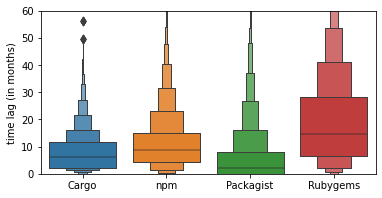

In [23]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='timelag',
    data=data.assign(timelag=lambda d: d['timelag'] / pandas.to_timedelta('30 day')),
    order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax,
)

ax.set(
    xlabel='',
    ylabel='time lag (in months)',
    ylim=(0, 60),
)

savefig(fig, 'need_timelag')

In [24]:
(
    data
    .assign(timelag=lambda d: d['timelag'] / pandas.to_timedelta('30 day'))
    .groupby('ecosystem')
    .apply(lambda d: d['timelag'].describe())
)

timelag,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,15516.0,7.554124,10.485656,-60.908777,2.129992,6.341589,11.583088,56.361447
Packagist,24673.0,6.124878,11.317407,-44.487167,0.000983,2.062725,7.960320,101.691821
Rubygems,2570.0,19.309934,18.024859,-28.730652,6.534049,14.759125,28.337279,104.056190
npm,383267.0,11.503991,11.548307,-81.491625,4.233987,8.857243,15.070653,103.785505


### Version-lag

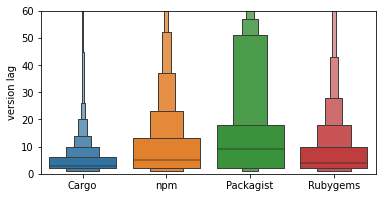

In [25]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='versionlag',
    data=data,
    order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax,
)

ax.set(
    xlabel='',
    ylabel='version lag',
    ylim=(0, 60),
)

savefig(fig, 'need_versionlag')

In [26]:
(
    data
    .groupby('ecosystem')
    .apply(lambda d: d['versionlag'].describe())
)

versionlag,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,15516.0,5.276940,8.341699,1.0,2.0,3.0,6.0,239.0
Packagist,24673.0,19.098164,34.333808,1.0,2.0,9.0,18.0,872.0
Rubygems,2570.0,11.475875,46.693701,1.0,2.0,4.0,10.0,907.0
npm,383267.0,11.708365,21.153103,1.0,2.0,5.0,13.0,1216.0


### Time lag in function of major branch

Since most dependency constraints allow patches and minor releases, one can expect that most of the technical lag is due to having missed a major release.
Let's quantify the time lag in function of the major branch being used.

In [27]:
data = pandas.concat([
    df_dependents[ecosystem]
    [['source', 'target', 'selected']]
    # Get highest release of target package
    .merge(
        df_required[ecosystem]
        .drop_duplicates('package', keep='last')
        [['package', 'rank', 'major', 'date']],
        how='inner',
        left_on='target',
        right_on='package',
    )
    # Get release for selected one
    .merge(
        df_required[ecosystem]
        [['package', 'rank', 'major', 'date']],
        how='inner',
        left_on=['target', 'selected'],
        right_on=['package', 'rank'],
        suffixes=(None, '_selected'),
    )
    .drop(columns=['package', 'package_selected'])
    .assign(timelag=lambda d: d['date'] - d['date_selected'])
    .assign(major_used=lambda d: d['major'] - d['major_selected'])
    .assign(major_used=lambda d: (d['major_used'].astype(int)).where(d['major_used'] < 3, '>3'))
    .replace({'major_used': {0: 'N', 1: 'N-1', 2: 'N-2', '>3': 'N-x'}})
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'source', 'target', 'timelag', 'major_used']]
    for ecosystem in ECOSYSTEMS],
)

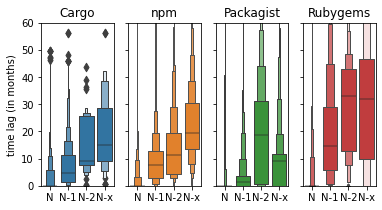

In [28]:
fig, axes = matplotlib.pyplot.subplots(ncols=len(ECOSYSTEMS), sharex=True, sharey=True)

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]

    seaborn.boxenplot(
        x='major_used',
        y='timelag',
        data=data[lambda d: d['ecosystem'] == ecosystem].assign(timelag=lambda d: d['timelag'] / pandas.to_timedelta('30 day')),
        color=COLORS[ecosystem],
        ax=ax,
    )
    ax.set(title=ecosystem, xlabel='', ylabel='')

axes[0].set(
    xlabel='',
    ylabel='time lag (in months)',
    ylim=(0, 60),
)

savefig(fig, 'need_timelag_per_major')

In [29]:
(
    data
    .assign(timelag=lambda d: d['timelag'] / pandas.to_timedelta('30 day'))
    .groupby(['ecosystem', 'major_used'])
    .apply(lambda d: d['timelag'].describe())
)

timelag                  count       mean        std        min        25%  \
ecosystem major_used                                                         
Cargo     N            55035.0   1.792179   4.845730 -21.433522   0.000000   
          N-1           3127.0   4.854200  17.582632 -60.908777   1.385473   
          N-2            135.0  13.993249   9.339237   0.247203   7.763285   
          N-x             77.0  19.597789  13.799229   0.490080   9.138406   
Packagist N            65119.0   0.735002   4.775399 -21.543014   0.000000   
          N-1          18815.0   3.999378   8.726344 -44.487167   0.000640   
          N-2           2052.0   9.778061  12.651635  -0.984316   0.003186   
          N-x            390.0  20.368287  19.347448  -7.038486   0.721338   
Rubygems  N            12851.0   1.737561   6.949194  -0.000318   0.000000   
          N-1           1048.0  19.554454  20.425945 -28.730652   5.850980   
          N-2            166.0  29.339230  18.378058  -0.674747  12.697562   
          N-x             61.0  31.700892  24.535113  -0.101605   9.796593   
npm       N           719249.0   1.521045   5.007250 -72.243261   0.000000   
          N-1         188737.0   9.490472  10.572488 -81.491625   2.906480   
          N-2          56059.0  14.353268  12.901091 -52.330857   4.233987   
          N-x          31449.0  22.870591  14.611025 -51.665804  13.607282   

timelag                     50%        75%         max  
ecosystem major_used                                    
Cargo     N            0.000000   0.000000   49.754143  
          N-1          4.863299  11.384103   56.268689  
          N-2          9.049450  25.507730   43.663282  
          N-x         14.964023  28.796185   56.361447  
Packagist N            0.000000   0.000000   83.940913  
          N-1          1.395862   3.782853  101.691821  
          N-2          9.059894  11.768882   91.650676  
          N-x         18.662101  31.034047   80.798486  
Rubygems  N            0.000000   0.000000   89.916286  
          N-1         14.759125  28.932155  104.056190  
          N-2         32.895983  42.867659   78.137107  
          N-x         31.963380  46.659194   97.914278  
npm       N            0.000000   0.000000   93.847026  
          N-1          7.771746  12.853316  103.785505  
          N-2         11.327774  19.424812   99.704604  
          N-x         19.499763  30.330189  102.021769

## Number of major releases used by dependent packages

Since many dependents make use of a previous major release, let's quantify, given a required package, the number of distinct major being used by dependent packages.

In [30]:
data = pandas.concat([
    df_required[ecosystem]
    # Get the number of distinct major for each package
    .merge(
        df_required[ecosystem]
        .drop_duplicates(['package', 'major'])
        .groupby('package', as_index=False, sort=False)
        .agg({'major': 'count'})
        .rename(columns={'major': 'nb_major'}),
        how='left',
        on='package',
    )
    # Get the number of major used for each package. 
    .merge(
        df_required[ecosystem]
        [['package', 'rank', 'major']]
        .merge(
            df_dependents[ecosystem]
            [['target', 'selected']],
            how='right',
            left_on=['package', 'rank'],
            right_on=['target', 'selected'],
            suffixes=(None, '_selected'),
        )
        .drop(columns=['target', 'selected'])
        .drop_duplicates(['package', 'major'])
        .groupby('package', sort=False, as_index=False)
        .agg({'major': 'count'})
        .rename(columns={'major': 'used_major'})
    )
    [['package', 'nb_major', 'used_major']]
    .drop_duplicates()
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
)

### Number of available major releases

Let's first quantify the number of major releases that are available for each required package.

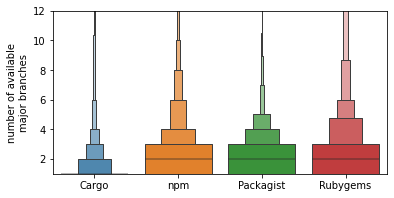

In [31]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='nb_major',
    data=data,
    order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax
)

ax.set(
    xlabel='',
    ylabel='number of available\nmajor branches',
    ylim=(1, 12),
)

savefig(fig, 'need_number_major_available')

In [32]:
(
    data
    .groupby('ecosystem')
    .apply(lambda d: d['nb_major'].describe())
)

nb_major,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,1181.0,2.947502,31.385827,1.0,1.0,1.0,1.0,637.0
Packagist,2184.0,2.175824,1.581281,1.0,1.0,2.0,3.0,18.0
Rubygems,651.0,3.118280,5.476649,1.0,1.0,2.0,3.0,54.0
npm,15118.0,2.546898,2.643691,1.0,1.0,2.0,3.0,96.0


Or, using another way of showing things:

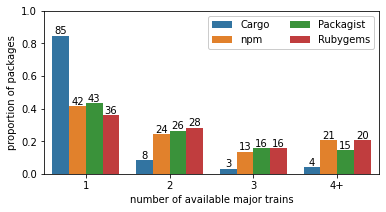

In [33]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .assign(nb_major=lambda d: d['nb_major'].where(d['nb_major'] < 4, '4+'))
    .groupby(['nb_major', 'ecosystem'])
    .agg({'package': 'count'})
    .pipe(lambda df:
        df.div(df.groupby('ecosystem').agg({'package': 'sum'}))
    )
    .reset_index()
)

seaborn.barplot(
    x='nb_major',
    y='package',
    hue='ecosystem',
    hue_order=ECOSYSTEMS,
    data=temp,
    palette=COLORS,
    ax=ax,
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, label in enumerate([1, 2, 3, '4+']):
        value = temp[lambda d: (d['ecosystem'] == ecosystem) & (d['nb_major'] == label)].iloc[0].package
        x = j + (i * 0.2 - 0.30)
        ax.annotate('{:.0f}'.format(value * 100), (x, value + 0.03), ha='center', va='center')


ax.legend(title=None, ncol=2)

ax.set(
    xlabel='number of available major trains',
    ylabel='proportion of packages',
    ylim=(0, 1),
)

savefig(fig, 'need_number_major_available_barplot')

### Number of used major releases

Since from 36% to 85% (Cargo!) packages have only a single major version, we only consider packages having at least 2 major releases for the following analyses.

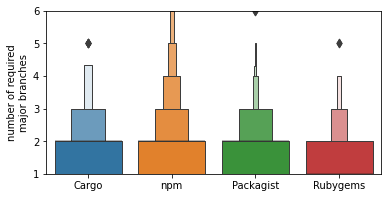

In [34]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='used_major',
    data=data[lambda d: d['nb_major'] > 1],
    palette=COLORS,
    order=ECOSYSTEMS,
    ax=ax
)

ax.set(
    xlabel='',
    ylabel='number of required\nmajor branches',
    ylim=(1, 6),
)

savefig(fig, 'need_number_used_major')

In [35]:
(
    data
    [lambda d: d['nb_major'] > 1]
    .groupby('ecosystem')
    .apply(lambda d: d['used_major'].describe())
)

used_major,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,182.0,1.796703,0.984628,1.0,1.0,2.0,2.0,8.0
Packagist,1240.0,1.725000,0.823987,1.0,1.0,2.0,2.0,7.0
Rubygems,418.0,1.614833,0.778900,1.0,1.0,1.0,2.0,5.0
npm,8832.0,2.023211,1.283601,1.0,1.0,2.0,2.0,30.0


Again, using a barplot:

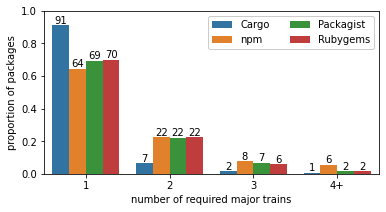

In [36]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .assign(used_major=lambda d: d['used_major'].where(d['used_major'] < 4, '4+'))
    .groupby(['used_major', 'ecosystem'])
    .agg({'package': 'count'})
    .pipe(lambda df:
        df.div(df.groupby('ecosystem').agg({'package': 'sum'}))
    )
    .reset_index()
)

seaborn.barplot(
    x='used_major',
    y='package',
    hue='ecosystem',
    hue_order=ECOSYSTEMS,
    data=temp,
    palette=COLORS,
    ax=ax,
)
6
for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, label in enumerate([1, 2, 3, '4+']):
        value = temp[lambda d: (d['ecosystem'] == ecosystem) & (d['used_major'] == label)].iloc[0].package
        x = j + (i * 0.2 - 0.30)
        ax.annotate('{:.0f}'.format(100 * value), (x, value + 0.03), ha='center', va='center')


ax.legend(title=None, ncol=2)

ax.set(
    xlabel='number of required major trains',
    ylabel='proportion of packages',
    ylim=(0, 1),
)

savefig(fig, 'need_number_used_major_barplot')

Restricted to packages having at least 2 majors:

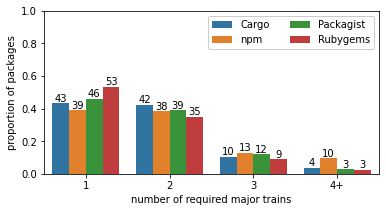

In [37]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    [lambda d: d['nb_major'] > 1]
    .assign(used_major=lambda d: d['used_major'].where(d['used_major'] < 4, '4+'))
    .groupby(['used_major', 'ecosystem'])
    .agg({'package': 'count'})
    .pipe(lambda df:
        df.div(df.groupby('ecosystem').agg({'package': 'sum'}))
    )
    .reset_index()
)

seaborn.barplot(
    x='used_major',
    y='package',
    hue='ecosystem',
    hue_order=ECOSYSTEMS,
    data=temp,
    palette=COLORS,
    ax=ax,
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, label in enumerate([1, 2, 3, '4+']):
        value = temp[lambda d: (d['ecosystem'] == ecosystem) & (d['used_major'] == label)].iloc[0].package
        x = j + (i * 0.2 - 0.30)
        ax.annotate('{:.0f}'.format(100 * value), (x, value + 0.03), ha='center', va='center')


ax.legend(title=None, ncol=2)

ax.set(
    xlabel='number of required major trains',
    ylabel='proportion of packages',
    ylim=(0, 1),
)

savefig(fig, 'need_number_used_major_min_2_major_barplot')

### Proportion of used major releases

Let's do the same, but proportionally to the total number of major releases available. 

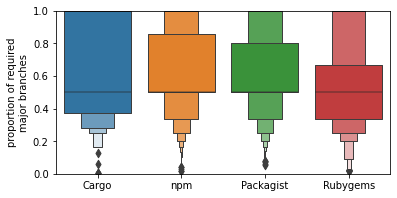

In [38]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='prop_major',
    order=ECOSYSTEMS,
    data=data[lambda d: d['nb_major'] > 1].eval('prop_major=used_major / nb_major'),
    palette=COLORS,
    ax=ax
)

ax.set(
    xlabel='',
    ylabel='proportion of required\nmajor branches',
    ylim=(0, 1),
)

savefig(fig, 'need_prop_major')

In [39]:
(
    data
    [lambda d: d['nb_major'] > 1]
    .eval('prop_major=used_major / nb_major')
    .groupby('ecosystem')
    .apply(lambda d: d['prop_major'].describe())
)

prop_major,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,182.0,0.625628,0.297954,0.003140,0.375000,0.5,1.000000,1.0
Packagist,1240.0,0.611300,0.255812,0.055556,0.500000,0.5,0.800000,1.0
Rubygems,418.0,0.547036,0.266669,0.018519,0.333333,0.5,0.666667,1.0
npm,8832.0,0.618504,0.258610,0.016393,0.500000,0.5,0.857143,1.0


# On the prevalence of backported updates

## Evolution of the number of packages with backports

In [40]:
data = pandas.concat([
    df_required[ecosystem]
    .assign(
        pkg_first=lambda d: ~d['package'].duplicated(),
        backport_first=lambda d: ~d[['package', 'backported']].duplicated() & d['backported'],
        release=1,
        backports=lambda d: d['backported'].astype(int),
    )
    .set_index('date')
    [['pkg_first', 'backport_first', 'release', 'backports']]
    .sort_index()
    .cumsum()
    .assign(
        packages=lambda d: d['backport_first'] / d['pkg_first'],
        releases=lambda d: d['backports'] / d['release'],
    )
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

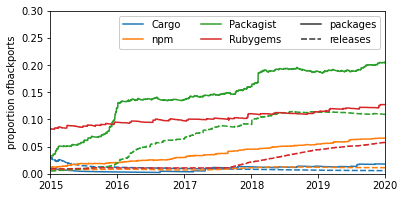

In [41]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.lineplot(
    x='date',
    y='value',
    hue='ecosystem',
    style='variable',
    data=pandas.melt(data, id_vars=['ecosystem', 'pkg_first', 'backport_first', 'release', 'backports'], value_vars=['packages', 'releases'], ignore_index=False),
    palette=COLORS,
    hue_order=ECOSYSTEMS,
    style_order=['packages', 'releases'],
    ci=None,  # speed-up
    ax=ax
)

handles, labels = ax.get_legend_handles_labels()
selection = list(range(1, len(ECOSYSTEMS) + 1)) + [-2, -1]
ax.legend(np.take(handles, selection), np.take(labels, selection), title=None, ncol=3)

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion ofbackports',
    ylim=(0, 0.3),
)

savefig(fig, 'prev_prop_packages_releases')

In [42]:
(
    data
    .groupby('ecosystem')
    .last()
)

,pkg_first,backport_first,release,backports,packages,releases
ecosystem,,,,,,
Cargo,1185,21,26185,149,0.017722,0.005690
Packagist,2247,457,100870,10886,0.203382,0.107921
Rubygems,652,83,35264,2036,0.127301,0.057736
npm,15281,1010,570676,6425,0.066095,0.011259


Not all packages can have backports (i.e., only those that have at least 2 major branches). Let's compute the proportion of packages with backports w.r.t. packages that could have backports:

In [43]:
(
    pandas.concat([
        df_required[ecosystem]
        .groupby('package', sort=False, as_index=False)
        .agg({'backported': 'max', 'major': 'nunique'})
        [lambda d: d['major']  > 1]
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS]
    )
    .groupby('ecosystem')
    .agg({'package': 'count', 'backported': 'sum'})
    .assign(p=lambda d: d['backported'] / d['package'])
)

,package,backported,p
ecosystem,,,
Cargo,182,21,0.115385
Packagist,1272,457,0.359277
Rubygems,418,83,0.198565
npm,8870,1010,0.113867


Evolution in absolute numbers:

[(0.0, 10000.0), Text(0, 0.5, 'backports')]

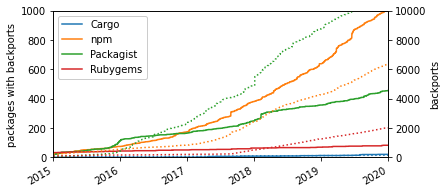

In [44]:
fig, ax = matplotlib.pyplot.subplots()

for ecosystem in ECOSYSTEMS:
    _ = (
        data[lambda d: d['ecosystem'] == ecosystem]
        [['backport_first', 'backports']]
        .rename(columns={'backport_first': ecosystem})
    )
    
    ax = _[[ecosystem]].plot(style='-', color=COLORS[ecosystem], ax=ax)
    sax = _[['backports']].plot(secondary_y=True, legend=False, style=':', color=COLORS[ecosystem], ax=ax)
    
ax.set(
    xlim=DATE_RANGE,
    xlabel='', 
    ylim=(0, 1000),
    ylabel='packages with backports',
)

sax.set(
    ylim=(0, 10000),
    ylabel='backports',
)

In [45]:
data

,pkg_first,backport_first,release,backports,packages,releases,ecosystem
date,,,,,,,
2014-11-11 00:22:07,1,0,1,0,0.000000,0.000000,Cargo
2014-11-11 05:37:15,2,0,2,0,0.000000,0.000000,Cargo
2014-11-11 05:37:31,3,0,3,0,0.000000,0.000000,Cargo
2014-11-11 05:37:37,4,0,4,0,0.000000,0.000000,Cargo
2014-11-11 05:37:45,5,0,5,0,0.000000,0.000000,Cargo
...,...,...,...,...,...,...,...
2020-01-12 00:24:18,652,83,35260,2036,0.127301,0.057742,Rubygems
2020-01-12 01:13:59,652,83,35261,2036,0.127301,0.057741,Rubygems
2020-01-12 19:48:55,652,83,35262,2036,0.127301,0.057739,Rubygems


## Proportion of backported releases for packages with backports

In [46]:
data = pandas.concat([
    df_required[ecosystem]
    .groupby('package', as_index=False, sort=False)
    .agg({
        'version': 'count',
        'backported': 'sum',
    })
    # Remove packages with no backport
    [lambda d: d['backported'] > 0]
    .assign(prop=lambda d: d['backported'] / d['version'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

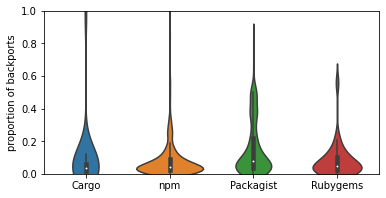

In [47]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.violinplot(
    x='ecosystem',
    y='prop',
    data=data,
    order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax,
)

ax.set(
    xlabel='',
    ylabel='proportion of backports',
    ylim=(0, 1),
)

savefig(fig, 'prev_prop_releases')

In [48]:
(
    data
    .groupby('ecosystem')
    .apply(lambda g: g['prop'].describe())
)

prop,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,21.0,0.089929,0.208263,0.004878,0.017544,0.035714,0.061224,0.983333
Packagist,457.0,0.154782,0.162862,0.003155,0.033113,0.081081,0.220339,0.825243
Rubygems,83.0,0.082513,0.108938,0.006024,0.021391,0.045045,0.100000,0.586592
npm,1010.0,0.082332,0.113916,0.000663,0.022185,0.044694,0.090909,0.955556


## Proportion of major branches with backported releases

We count the number of major branches that have at least one backported release. 
Since packages with no backported releases won't have such major branches, we exclude them from the analysis. 
Also, notice that all packages (with backports) have at least one major branch without backported release (the last one), by definition. 

Consequently, if a package has `N>=2` major branches, it can have `[1, N-1]` majors with backports.

In [49]:
data = pandas.concat([
    df_required[ecosystem]
    # Keep only packages with backported releases
    .groupby('package', sort=False, as_index=False)
    .filter(lambda g: g['backported'].max())
    # Identify major branches
    .groupby(['package', 'major'], sort=False, as_index=False)
    .agg({'backported': 'max'})
    .groupby('package', sort=False, as_index=False)
    .agg({'major': 'count', 'backported': 'sum'})
    .assign(proportion=lambda d: d['backported'] / d['major'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

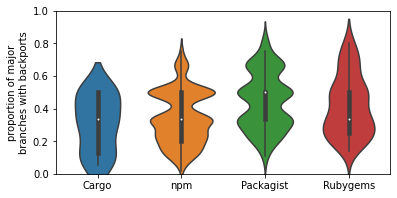

In [50]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.violinplot(
    x='ecosystem',
    y='proportion',
    data=data,
    palette=COLORS,
    ax=ax,
)

ax.set(
    xlabel='',
    ylabel='proportion of major\nbranches with backports',
    ylim=(0, 1), 
)

savefig(fig, 'prev_prop_major_with_backports')

In [51]:
(
    data
    .groupby('ecosystem')
    .apply(lambda g: g.describe())
)

major   backported   proportion
ecosystem                                             
Cargo     count    21.000000    21.000000    21.000000
          mean      5.523810     1.047619     0.307768
          std       4.728838     0.218218     0.169084
          min       2.000000     1.000000     0.055556
          25%       2.000000     1.000000     0.125000
          50%       3.000000     1.000000     0.333333
          75%       8.000000     1.000000     0.500000
          max      18.000000     2.000000     0.500000
Packagist count   457.000000   457.000000   457.000000
          mean      3.544858     1.481400     0.444409
          std       1.604086     0.797600     0.172980
          min       2.000000     1.000000     0.071429
          25%       3.000000     1.000000     0.333333
          50%       3.000000     1.000000     0.500000
          75%       4.000000     2.000000     0.500000
          max      14.000000     6.000000     0.833333
Rubygems  count    83.000000    83.000000    83.000000
          mean      4.024096     1.662651     0.417942
          std       1.886899     1.261794     0.182036
          min       2.000000     1.000000     0.142857
          25%       3.000000     1.000000     0.250000
          50%       4.000000     1.000000     0.333333
          75%       5.000000     2.000000     0.500000
          max      13.000000     8.000000     0.800000
npm       count  1010.000000  1010.000000  1010.000000
          mean      4.622772     1.266337     0.345819
          std       4.572646     0.722946     0.160648
          min       2.000000     1.000000     0.015385
          25%       3.000000     1.000000     0.200000
          50%       4.000000     1.000000     0.333333
          75%       5.000000     1.000000     0.500000
          max      96.000000     8.000000     0.750000

Let's visualize the proportion of packages (regardless of the ecosystem) for each "case": 

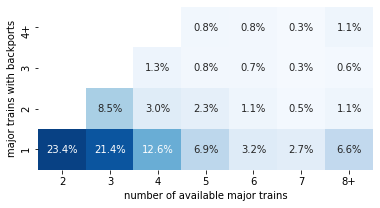

In [52]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        data
        .assign(
            major=lambda d: d['major'].where(d['major'] < 8, '8+'),
            backported=lambda d: d['backported'].astype(str).where(d['backported'] < 4, '4+'),
        )
        .groupby(['major', 'backported'], as_index=False)
        .agg({'package': 'count'})
        .pivot(index='major', columns='backported', values='package')
        .div(len(data))
        .T
        .sort_index(ascending=False)
    ),
    vmin=0, 
    vmax=0.25, 
    annot=True,
    cmap='Blues',
    fmt='.1%',
    cbar=False,
    cbar_kws={'label': 'proportion of packages'},
    ax=ax
)

ax.set(
    xlabel='number of available major trains',
    ylabel='major trains with backports',
)

savefig(fig, 'prev_prop_major_with_backports_all')

### Do packages with backports exhibit different characteristics?

Number of dependents, their timelag and number of major branches used will be analysed later.

In [53]:
data = pandas.concat([
    df_required[ecosystem]
    .groupby(['package'], sort=False, as_index=False)
    .agg(
        first=('date', 'min'),
        last=('date', 'max'),
        releases=('version', 'count'),
        backports=('backported', 'sum'),
        backport=('backported', 'max'),
    )
    # Remove single release packages, since age is 0 and frequency is inf
    [lambda d: d['releases'] > 1]
    .assign(age=lambda d: (d['last'] - d['first']) / pandas.to_timedelta('365 days'))
    .assign(frequency=lambda d: (d['releases'] - d['backports']) / d['age'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS], axis=0
)

#### Package age

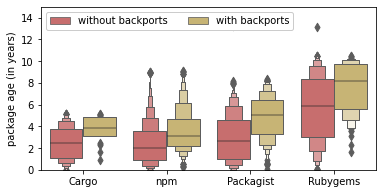

In [54]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='age',
    hue='backport',
    data=(
        data
        .replace({'backport': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2, loc='upper left')

ax.set(
    xlabel='',
    ylabel='package age (in years)',
    ylim=(0, 15),
)

savefig(fig, 'char_package_age')

In [55]:
print(
    data
    .groupby(['ecosystem', 'backport'])
    .age.describe()
    .to_string()
)

                      count      mean       std           min       25%       50%       75%        max
ecosystem backport                                                                                    
Cargo     False      1106.0  2.474859  1.513396  8.298453e-05  1.081892  2.471819  3.762565   5.166968
          True         21.0  3.703725  1.227875  8.742058e-01  3.109296  3.859930  4.843809   5.155217
Packagist False      1747.0  2.928029  2.159560  0.000000e+00  0.988710  2.637922  4.597942  13.203131
          True        457.0  4.865418  1.999025  8.586200e-02  3.336990  5.003902  6.452967   8.358232
Rubygems  False       567.0  5.646571  3.071915  5.707763e-07  3.000789  5.843521  8.310552  13.138149
          True         83.0  7.573654  2.303871  1.614320e+00  5.627684  8.173537  9.734118  10.471950
npm       False     13838.0  2.406072  1.898542  1.204972e-06  0.865093  2.014469  3.525708   9.037212
          True       1010.0  3.586221  1.932858  2.514626e-01  2.156691  

In [56]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backport'] > 0)].age
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backport'] == 0)].age
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.00013; d=0.466 (medium)
npm        with vs. without: p=0.00000; d=0.367 (medium)
Packagist  with vs. without: p=0.00000; d=0.487 (large)
Rubygems   with vs. without: p=0.00000; d=0.366 (medium)


#### Number of releases

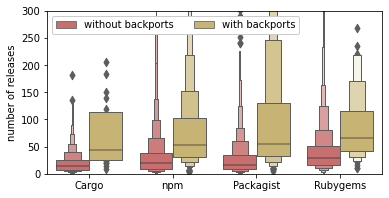

In [57]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='releases',
    hue='backport',
    data=(
        data
        .replace({'backport': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2, loc='upper left')

ax.set(
    xlabel='',
    ylabel='number of releases',
    ylim=(0, 300),
)

savefig(fig, 'char_package_releases')

In [58]:
print(
    data
    .groupby(['ecosystem', 'backport'])
    .releases.describe()
    .to_string()
)

                      count        mean         std   min   25%   50%    75%     max
ecosystem backport                                                                  
Cargo     False      1106.0   22.301989   37.121924   2.0   7.0  14.5   26.0   637.0
          True         21.0   69.571429   59.180716   9.0  25.0  44.0  114.0   205.0
Packagist False      1747.0   29.866629   46.105064   2.0   8.0  16.0   34.0  1174.0
          True        457.0  106.455142  125.325675   5.0  32.0  55.0  131.0  1339.0
Rubygems  False       567.0   45.530864   55.743881   2.0  17.0  29.0   52.0   491.0
          True         83.0  113.807229  171.050945  10.0  42.5  65.0  116.0   969.0
npm       False     13838.0   34.468203   63.037991   2.0   9.0  19.0   39.0  3907.0
          True       1010.0   92.348515  193.829775   4.0  31.0  53.5  103.0  4433.0


In [59]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backport'] > 0)].releases
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backport'] == 0)].releases
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.00000; d=0.659 (large)
npm        with vs. without: p=0.00000; d=0.568 (large)
Packagist  with vs. without: p=0.00000; d=0.635 (large)
Rubygems   with vs. without: p=0.00000; d=0.547 (large)


#### Release frequency

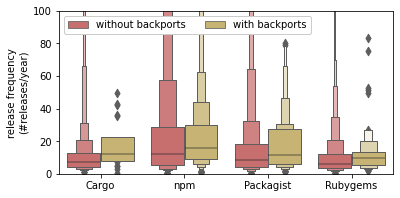

In [60]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='frequency',
    hue='backport',
    data=(
        data
        .replace({'backport': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2, loc='upper left')

ax.set(
    xlabel='',
    ylabel='release frequency\n(#releases/year)',
    ylim=(0, 100),
)

savefig(fig, 'char_package_frequency')

In [61]:
print(
    data
    .groupby(['ecosystem', 'backport'])
    .frequency.describe()
    [['count', 'mean', '50%']]
    .to_string()
)

                      count         mean        50%
ecosystem backport                                 
Cargo     False      1106.0   109.723284   7.426905
          True         21.0    17.163860  12.009046
Packagist False      1747.0          inf   8.336084
          True        457.0    18.516708  11.546640
Rubygems  False       567.0  9339.222027   5.953315
          True         83.0    13.149252   9.873349
npm       False     13838.0   972.990056  11.996832
          True       1010.0    29.671051  15.999950


In [62]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backport'] > 0)].frequency
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backport'] == 0)].frequency
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.01396; d=0.280 (small)
npm        with vs. without: p=0.00000; d=0.150 (small)
Packagist  with vs. without: p=0.00000; d=0.191 (small)
Rubygems   with vs. without: p=0.00023; d=0.238 (small)


## Relation between backports and dependents

We see whether there is relation between the presence of backports and the number of dependent packages.

In [63]:
data = pandas.concat([
    df_required[ecosystem]
    # Get dependents for each release
    .merge(
        df_dependents[ecosystem]
        [['source', 'target', 'selected']],
        how='left',
        left_on=['package', 'rank'],
        right_on=['target', 'selected']
    )
    # Group per major release, and count dependents
    .groupby(['package', 'major'], as_index=False)
    .agg({'source': 'count', 'backported': 'sum'})
    # For each package, get nb major, used major, dependents and backports
    .assign(used_major=lambda d: d['source'] > 0)
    .groupby('package', as_index=False, sort=False)
    .agg(
        major=('major', 'count'),
        used_major=('used_major', 'sum'),
        backports=('backported', 'sum')
    )
    .merge(
        df_dependents[ecosystem]
        .groupby('target', sort=False, as_index=False)
        .agg(dependents=('source', 'count')),
        how='left',
        left_on='package',
        right_on='target',
    )
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

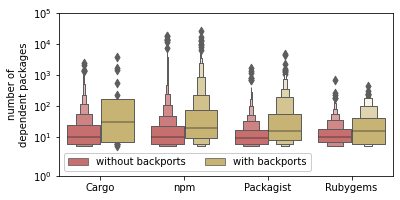

In [64]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='dependents',
    hue='backports',
    data=(
        data
        .assign(backports=lambda d: d['backports'] > 0)
        .replace({'backports': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2)

ax.set(
    xlabel='',
    ylabel='number of\ndependent packages',
    yscale='symlog',
    ylim=(1, 10e4),
)

savefig(fig, 'prev_backport_dependents')

In [65]:
(
    data
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .groupby(['ecosystem', 'backports'])
    .apply(lambda g: g[['dependents']].describe())
    .unstack()
)

dependents                                     \
                                 count        mean          std  min  25%   
ecosystem backports                                                         
Cargo     with backports          21.0  383.571429   871.701587  5.0  7.0   
          without backports     1164.0   44.466495   157.653761  5.0  6.0   
Packagist with backports         457.0  108.234136   372.454995  5.0  8.0   
          without backports     1790.0   22.460335    73.742973  5.0  6.0   
Rubygems  with backports          83.0   45.783133    75.329204  5.0  6.0   
          without backports      569.0   19.799649    37.548962  5.0  7.0   
npm       with backports        1010.0  279.304950  1360.764012  5.0  9.0   
          without backports    14271.0   51.835541   373.278294  5.0  6.0   

                                                    
                              50%     75%      max  
ecosystem backports                                 
Cargo     with backports     31.0  172.00   3647.0  
          without backports  10.0   24.00   2466.0  
Packagist with backports     16.0   56.00   4844.0  
          without backports   9.0   16.75   1648.0  
Rubygems  with backports     15.0   41.00    420.0  
          without backports  10.0   18.00    664.0  
npm       with backports     20.0   72.00  26163.0  
          without backports  10.0   22.00  18354.0

Is there a statistical difference between these distributions?

In [66]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] > 0)].dependents
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] == 0)].dependents
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.00802; d=0.305 (small)
npm        with vs. without: p=0.00000; d=0.311 (small)
Packagist  with vs. without: p=0.00000; d=0.328 (small)
Rubygems   with vs. without: p=0.00354; d=0.182 (small)


## Relation between backports and used major

We see whether there is a relation between the presence of backports and the number of major releases being used.
We exclude packages having only one major since it wouldn't be fair to compare them with packages having backports (given a backport needs at least 2 major).

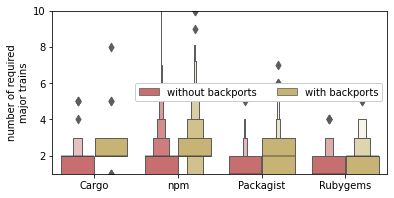

In [67]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='used_major',
    hue='backports',
    data=(
        data
        [lambda d: d['major'] >= 2]
        .assign(backports=lambda d: d['backports'] > 0)
        .replace({'backports': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2)

ax.set(
    xlabel='',
    ylabel='number of required\nmajor trains',
    ylim=(1, 10),
)

savefig(fig, 'prev_backport_used_major')

In [68]:
(
    data
    [lambda d: d['major'] >= 2]
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .groupby(['ecosystem', 'backports'])
    .apply(lambda g: g[['used_major']].describe())
    .unstack()
)

used_major                                     \
                                 count      mean       std  min  25%  50%   
ecosystem backports                                                         
Cargo     with backports          21.0  2.523810  1.661898  1.0  2.0  2.0   
          without backports      161.0  1.701863  0.820402  1.0  1.0  2.0   
Packagist with backports         457.0  2.122538  0.947223  0.0  1.0  2.0   
          without backports      815.0  1.434356  0.688835  0.0  1.0  1.0   
Rubygems  with backports          83.0  1.951807  1.010960  1.0  1.0  2.0   
          without backports      335.0  1.531343  0.686528  1.0  1.0  1.0   
npm       with backports        1010.0  2.526733  1.630294  0.0  2.0  2.0   
          without backports     7860.0  1.948728  1.221407  0.0  1.0  2.0   

                                        
                             75%   max  
ecosystem backports                     
Cargo     with backports     3.0   8.0  
          without backports  2.0   5.0  
Packagist with backports     3.0   7.0  
          without backports  2.0   5.0  
Rubygems  with backports     2.0   5.0  
          without backports  2.0   4.0  
npm       with backports     3.0  15.0  
          without backports  2.0  30.0

In [69]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] > 0) & (d['major'] >= 2)].used_major
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] == 0) & (d['major'] >= 2)].used_major
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.00293; d=0.340 (medium)
npm        with vs. without: p=0.00000; d=0.237 (small)
Packagist  with vs. without: p=0.00000; d=0.428 (medium)
Rubygems   with vs. without: p=0.00018; d=0.226 (small)


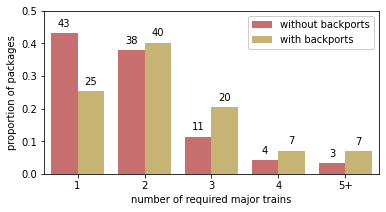

In [70]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    [lambda d: (d['major'] >= 2) & (d['used_major'] >= 1)]
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .assign(used_major=lambda d: d['used_major'].where(d['used_major'] < 5, '5+'))
    .groupby(['used_major', 'backports'])
    .agg({'package': 'count'})
    .groupby('backports')
    .apply(lambda g: g / g.sum())
    .reset_index()
)


seaborn.barplot(
    x='used_major',
    y='package', 
    hue='backports',
    hue_order=['without backports', 'with backports'],
    data=temp,
    palette=PAL_REL,
    ax=ax,
)


for i, backports in enumerate(['without backports', 'with backports']):
    for j, label in enumerate([1, 2, 3, 4, '5+']):
        value = temp[lambda d: (d['backports'] == backports) & (d['used_major'] == label)].iloc[0].package
        x = j - 0.20 if i == 0 else j + 0.20
        ax.annotate('{:.0f}'.format(100 * value), (x, value + 0.03), ha='center', va='center')


ax.legend(title=None, ncol=1)

ax.set(
    xlabel='number of required major trains',
    ylabel='proportion of packages',
    ylim=(0, 0.5),
)

savefig(fig, 'prev_backport_used_major_barplot')

### Does depending on a package with backport imply using older major trains?

In [72]:
data = pandas.concat([
    df_dependents[ecosystem]
    [['source', 'target', 'selected']]
    # Get selected release
    .merge(
        df_required[ecosystem][['package', 'rank', 'major']],
        how='inner',
        left_on=['target', 'selected'],
        right_on=['package', 'rank'],
    )
    .drop(columns=['package'])
    # Does target have backports?
    .assign(backports=lambda d: d['target'].isin(df_required[ecosystem].query('backported').package))
    # Get major rank
    .merge(
        df_required[ecosystem]
        [['package', 'major']]
        .drop_duplicates()
        .assign(major_rank=lambda d: d.groupby('package').cumcount() + 1),
        how='left', 
        left_on=['target', 'major'],
        right_on=['package', 'major'],
    )
    .drop(columns=['package'])
    # Get highest major rank
    .merge(
        df_required[ecosystem]
        [['package', 'major']]
        .drop_duplicates()
        .assign(highest_major_rank=lambda d: d.groupby('package').cumcount() + 1)
        .groupby('package', sort=False, as_index=False)
        .agg({'highest_major_rank': 'max'}),
        how='left', 
        left_on=['target'],
        right_on=['package'],
    )
    .drop(columns=['package'])
    # Keep only required packages that have at least 2 majors
    [lambda d: d['highest_major_rank'] >= 2]
    .assign(diff=lambda d: d['highest_major_rank'] - d['major_rank'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS], axis=0
)

In [73]:
_ = (
    data
    .assign(diff=lambda d: d['diff'].where(d['diff'] < 5, '5+'))
    .groupby(['ecosystem', 'backports', 'diff'])
    .agg(dependents=('source', 'count'))
    .pipe(lambda df: df / df.groupby(['ecosystem', 'backports']).sum())
    .unstack()
)

_.style.format('{:.1%}').background_gradient(vmin=0, vmax=1, axis=1)

In [74]:
print(_.to_string())

                    dependents                                                  
diff                         0         1         2         3         4        5+
ecosystem backports                                                             
Cargo     False       0.816744  0.171987  0.008190  0.001680  0.000770  0.000630
          True        0.910490  0.083551  0.001862  0.001490  0.000993  0.001614
Packagist False       0.763654  0.226862  0.007027  0.002057  0.000286  0.000114
          True        0.642835  0.312081  0.039513  0.004798  0.000584  0.000188
Rubygems  False       0.881707  0.101325  0.011797  0.003878  0.000970  0.000323
          True        0.840622  0.124450  0.026416  0.006164  0.001468  0.000881
npm       False       0.641687  0.262767  0.058554  0.021309  0.008041  0.007642
          True        0.663483  0.206908  0.092122  0.019873  0.008874  0.008740


## Dependent packages relying on backported releases

Dependent packages could benefit from backports if they allow such updates through dependency constraints. 
For this analysis, we look at all major branches that have backports, and we identify dependent packages that benefit from such backports. 

In [75]:
data = pandas.concat([
    df_dependents[ecosystem]
    .drop(columns=['rank'])
    .merge(
        df_required[ecosystem]
        [['package', 'major', 'rank', 'backported']],
        how='inner',
        left_on=['target', 'selected'],
        right_on=['package', 'rank'],
    )
    # Identify major branches that have a backport
    .merge(
        df_required[ecosystem]
        .groupby(['package', 'major'], as_index=False, sort=False)
        .agg(
            backport=('backported', 'max'),
            first_rank=('rank', 'min'),
            last_rank=('rank', 'max'),
        ),
        how='inner',
        left_on=['package', 'major'],
        right_on=['package', 'major'],
    )
    # Keep only major that have backports
    [lambda d: d['backport']]
    [['source', 'target', 'selected', 'major', 'rank', 'backported', 'first_rank', 'last_rank']]
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

In [76]:
(
    data
    .groupby(['ecosystem'], as_index=False, sort=False)
    .agg(
        dependents=('source', 'count'),
        backported=('backported', 'sum'),
    )
    .assign(proportion=lambda d: d['backported'] / d['dependents'])
    .style
    .format({'proportion': '{:.1%}'})
    .bar(subset=['proportion'], vmin=0, vmax=1, color='lightblue')
)

,ecosystem,dependents,backported,proportion
0,Cargo,386,372,96.4%
1,npm,53015,44450,83.8%
2,Packagist,14737,13705,93.0%
3,Rubygems,310,254,81.9%


This shows that most packages depending on a major branch that has backported releases actually depend on such backported releases. 

## Depending on backported releases reduces time lag?

One can expect that depending on backports reduce technical lag. 
We compare in this analysis the time lag of packages depending on backported releases with the one of packages depending on non-backported releases.
We only consider packages having a technical lag (i.e. we excluded packages using the highest available version).

In [77]:
data = pandas.concat([
    df_dependents[ecosystem]
    [['source', 'target', 'selected']]
    # Get highest release of target package
    .merge(
        df_required[ecosystem]
        .drop_duplicates('package', keep='last')
        [['package', 'rank', 'date']],
        how='inner',
        left_on='target',
        right_on='package',
    )
    # Get release for selected one
    .merge(
        df_required[ecosystem]
        [['package', 'rank', 'date', 'backported']],
        how='inner',
        left_on=['target', 'selected'],
        right_on=['package', 'rank'],
        suffixes=(None, '_selected'),
    )
    # Ignore up-to-date releases
    [lambda d: d['rank'] != d['selected']]
    .drop(columns=['package', 'package_selected'])
    .assign(timelag=lambda d: d['date'] - d['date_selected'])
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'source', 'target', 'timelag', 'backported']]
    for ecosystem in ECOSYSTEMS],
)

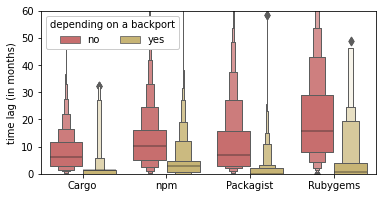

In [78]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='time',
    hue='backported',
    data=(
        data
        .assign(time=lambda d: d['timelag'] / pandas.to_timedelta('30 day'))
        .replace({'backported': {True: 'yes', False: 'no'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title='depending on a backport', ncol=2, loc='upper left')

ax.set(
    xlabel='',
    ylabel='time lag (in months)',
    ylim=(0, 60),
)

savefig(fig, 'prev_timelag_comparison')

In [79]:
(
    data
    .groupby(['ecosystem', 'backported'])
    .apply(lambda d: d['timelag'].describe())
    [['mean', '50%']]
)

timelag                                       mean                      50%
ecosystem backported                                                       
Cargo     False        250 days 18:49:46.926307444        190 days 05:56:39
          True       -757 days +01:01:31.416666664         45 days 05:41:31
Packagist False        352 days 18:31:31.009482128        208 days 02:24:15
          True          48 days 11:26:17.400583728          0 days 23:50:39
Rubygems  False        630 days 12:21:47.579447320 476 days 01:44:34.500000
          True         112 days 07:04:33.944881890         16 days 02:33:32
npm       False        376 days 01:56:33.282984632        302 days 05:22:45
          True         109 days 02:52:57.544184476         87 days 03:36:28

In [80]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & d['backported']].timelag / pandas.to_timedelta('30 day')
    B = data[lambda d: (d['ecosystem'] == ecosystem) & ~d['backported']].timelag / pandas.to_timedelta('30 day')
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.00000; d=-0.740 (large)
npm        with vs. without: p=0.00000; d=-0.597 (large)
Packagist  with vs. without: p=0.00000; d=-0.759 (large)
Rubygems   with vs. without: p=0.00000; d=-0.705 (large)


# How and when are releases backported?

## Backport release type

The type of a backport depends on the "source" release (the one being backported) and the "target" release (the one being the backport). We expect that most backports correspond to patches being backported as patches, but it could be the case that some minor release has its fixes being backported as patch as well.

In [81]:
data = pandas.concat([
    df_required[ecosystem]
    .merge(
        df_required[ecosystem].drop(columns=['backported', 'backported_from']),
        how='inner',
        left_on=['package', 'backported_from'],
        right_on=['package', 'rank'],
        suffixes=(None, '_from'),
    )
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

In [82]:
(
    data
    .groupby(['ecosystem', 'kind_from', 'kind'])
    .agg({'package': 'count'})
    .div(
        data
        .groupby('ecosystem')
        .agg({'package': 'count'})
    )
    .unstack()
    .merge(
        data
        .groupby(['ecosystem', 'kind_from', 'kind'])
        .agg({'package': 'count'})
        .unstack(),
        left_index=True,
        right_index=True,
        suffixes=('_prop', None)
    )
    .style
    .format('{:.1%}', subset='package_prop')
    .background_gradient(subset='package_prop', vmin=0, vmax=1, axis=None)
    .background_gradient(subset='package', axis=None)
)

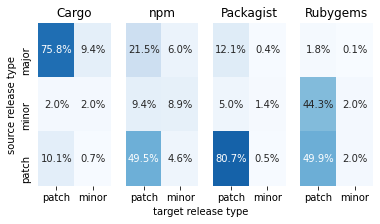

In [83]:
fig, axes = matplotlib.pyplot.subplots(ncols=4, sharex=True, sharey=True)

fig.set_size_inches(FIG_SIZE)

temp = (
    data
    .groupby(['ecosystem', 'kind_from', 'kind'])
    .agg({'package': 'count'})
    .div(
        data
        .groupby('ecosystem')
        .agg({'package': 'count'})
    )
    .unstack()
    .merge(
        data
        .groupby(['ecosystem', 'kind_from', 'kind'])
        .agg({'package': 'count'})
        .unstack(),
        left_index=True,
        right_index=True,
        suffixes=('_prop', None)
    )
    ['package_prop']
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    seaborn.heatmap(
        data=temp.loc[ecosystem][['patch', 'minor']],
        vmin=0, 
        vmax=1,
        annot=True,
        cmap='Blues',
        fmt='.1%',
        cbar=False,
        ax=ax
    )

    ax.set(
        title=ecosystem,
        xlabel='', 
        ylabel='',
    )
    
    ax.yaxis.set_ticks_position('none') 
    
    
axes[0].set(
    ylabel='source release type',
)
axes[1].set(
    # Ugly hack to center the label
    xlabel=(' ' * 25) + 'target release type',
)
    
savefig(fig, 'type_update_source_target')

Or, all package distributions combined:

In [84]:
(
    data
    .groupby(['kind_from', 'kind'])
    .agg({'package': 'count'})
    .div(len(data))
    .unstack()
    .style
    .format('{:.1%}', subset='package')
    .background_gradient(subset='package', vmin=0, vmax=1, axis=None)
)

## Major branches that receive and trigger backports

If a major has multiple backports, it is only counted once. 

In [85]:
nb_major = 7

temp = (
    data
    [['ecosystem', 'package', 'major', 'major_from']]
    .assign(major=lambda d: d['major'].astype(int).astype(str).where(d['major'] < (nb_major - 1), f'{nb_major - 1}+'))
    .assign(major_from=lambda d: d['major_from'].astype(int).astype(str).where(d['major_from'] < nb_major, f'{nb_major}+'))
    .groupby(['major_from', 'major'])
    .agg({'package': 'count'})
    .unstack()
    ['package']
    .rename_axis('major source')
    .rename_axis('major target', axis=1)
    .pipe(lambda df: df / df.sum().sum())

    .assign(total=lambda d: d.sum(axis=1))
)

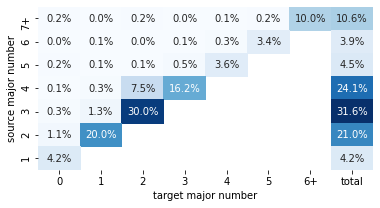

In [86]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        temp
        .sort_index(ascending=False)
    ),
    vmin=0, 
    annot=True,
    cmap='Blues',
    fmt='.1%',
    cbar=False,
    ax=ax
)

ax.set(
    xlabel='target major number',
    ylabel='source major number',
)

savefig(fig, 'type_major_source_target')

In [87]:

(
    data
    [['ecosystem', 'package', 'major', 'major_from']]
    .assign(diff=lambda d: d['major_from'] - d['major'])
    .assign(diff=lambda d: d['diff'].where(d['diff'] < nb_major, f'{nb_major}+'))
    .groupby(['diff'])
    .agg({'package': 'count'})
    .assign(package=lambda d: d['package'] / d['package'].sum())
    .style
    .background_gradient(vmin=0, axis=None)
    .format('{:.1%}', na_rep='')
)

,package
diff,
1.0,86.0%
2.0,11.9%
3.0,1.0%
4.0,0.4%
5.0,0.4%
6.0,0.0%
7+,0.2%


## Time to backport a release since a major

We expect that most backports are "quickly" released when a new major is available, in order to allow security or stability fixes to be available for dependents during their transition to the new major. 

Here, we assume that a "branch" (i.e. a major) is expected to be "abandonned" as soon as the next major is releases. Hence, we compute the time between the release date of the next major release and the release date of the backport. This merely corresponds to the question "How long does it take to release in a previous major-branch?".

More formally, for each major `N.0.0`, if there is a backport `(N-1).y.z`, we compute the time between `N.0.0` and `(N-1).y.z`.

In [88]:
data = pandas.concat([
    df_required[ecosystem]
    [lambda d: d['backported']]
    [['package', 'version', 'major', 'rank', 'rank_date', 'date']]
    .assign(next_major=lambda d: d['major'] + 1)
    # Get major release date
    .merge(
        df_required[ecosystem]
        [lambda d: d['kind'] == 'major']
        [['package', 'major', 'rank', 'rank_date', 'date']],
        how='inner',
        left_on=['package', 'next_major'],
        right_on=['package', 'major'],
        suffixes=(None, '_next_major'),
    )
    .drop(columns=['next_major'])
    .sort_values('rank_date')
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

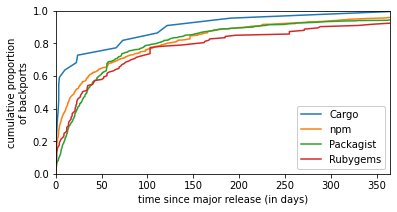

In [89]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.lineplot(
    x='time',
    y='cases',
    hue='ecosystem',
    data=(
        data
        .drop_duplicates(['ecosystem', 'package', 'major'], keep='first')
        .assign(time=lambda d: (d['date'] - d['date_next_major']) / pandas.to_timedelta('1 day'))
        .assign(cases=1)
        .sort_values('time')
        .groupby('ecosystem', sort=False)
        .apply(lambda g: g.assign(cases=lambda d: d['cases'].cumsum() / len(d)))
    ),
    palette=COLORS,
    hue_order=ECOSYSTEMS,
    ci=None,  # speed-up
    ax=ax
)

ax.legend(title=None)

ax.set(
    xlabel='time since major release (in days)',
    xlim=(0, 365),
    ylabel='cumulative proportion\nof backports',
    ylim=(0, 1),
)

savefig(fig, 'time_since_next_major')

In [90]:
(
    data
    .drop_duplicates(['ecosystem', 'package', 'major'], keep='first')
    .assign(time=lambda d: (d['date'] - d['date_next_major']) / pandas.to_timedelta('1 day'))
    .assign(cases=1)
    .sort_values('time')
    .groupby('ecosystem', sort=False, as_index=False)
    .apply(lambda g: g.assign(cases=lambda d: d['cases'].cumsum() / len(d)))
    [lambda d: d['cases'] >= 0.5]
    [['ecosystem', 'time', 'cases']]
    .groupby('ecosystem').first()
)

,time,cases
ecosystem,,
Cargo,3.343634,0.500000
Packagist,34.137431,0.500000
Rubygems,29.322720,0.503759
npm,20.848437,0.500418


Let's compare the time required to backport the first and the last update. 

In [91]:
temp = (
    data
    .groupby(['ecosystem', 'package', 'major'], sort=False, as_index=False)
    .agg(
        date_next_major=('date_next_major', 'first'),
        date_first=('date', 'first'),
        date_last=('date', 'last'),
    )
    .pipe(lambda df: 
        pandas.melt(df, id_vars=['ecosystem', 'package', 'major', 'date_next_major'], value_vars=['date_first', 'date_last'])
    )
    .assign(time=lambda d: (d['value'] - d['date_next_major']) / pandas.to_timedelta('30 day'))
    .replace({'variable': {'date_first': 'first', 'date_last': 'last'}})
)

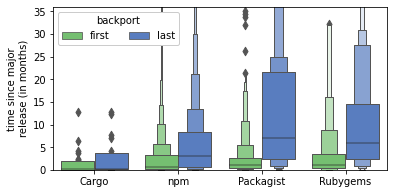

In [92]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='time',
    hue='variable',
    data=temp,
    order=ECOSYSTEMS,
    palette=np.take(PAL_REL, [2, 3], axis=0),
    ax=ax,
)

ax.legend(title='backport', ncol=2)

ax.set(
    xlabel='',
    ylabel='time since major\nrelease (in months)',
    ylim=(0, 36),
)

savefig(fig, 'time_since_next_major_boxenplot')

In [93]:
(
    temp
    .groupby(['ecosystem', 'variable'])
    .apply(lambda d: d['time'].describe())
)

time                 count       mean        std           min       25%  \
ecosystem variable                                                         
Cargo     first       22.0   1.562898   3.043591  2.642207e-02  0.046200   
          last        22.0   5.099231  13.075710  2.642207e-02  0.071299   
Packagist first      664.0   2.784827   4.717617  3.472222e-06  0.421111   
          last       664.0  12.069204  11.858829  7.986111e-05  2.412889   
Rubygems  first      133.0   4.580098  10.321725  1.412037e-04  0.368570   
          last       133.0  11.015864  12.667687  1.412037e-04  2.304100   
npm       first     1197.0   2.626799   5.039027  7.716049e-07  0.110360   
          last      1197.0   6.169227   8.780220  7.716049e-07  0.676645   

time                     50%        75%        max  
ecosystem variable                                  
Cargo     first     0.111469   1.848293  12.869686  
          last      0.260965   3.644902  60.908777  
Packagist first     1.138641   2.633949  35.087022  
          last      7.105937  21.487746  53.921062  
Rubygems  first     0.977424   3.430239  63.138760  
          last      5.826799  14.607347  63.138760  
npm       first     0.694948   3.195595  45.698297  
          last      2.963813   8.397391  81.491625

## Extended support for major with backports

One can expect that major releases receiving backported updates are supported longer than the ones that do not receive backports.

By "support", we mean the time between the very first and very last release of a major branch.

In [94]:
data = pandas.concat([
    df_required[ecosystem]
    .groupby(['package', 'major'], sort=False, as_index=False)
    .agg(
        backport=('backported', 'max'),
        date_first=('date', 'first'),
        date_last=('date', 'last'),
        rank_first=('rank', 'first'),
        rank_last=('rank', 'last'),
    )
    .assign(time=lambda d: (d['date_last'] - d['date_first']) / pandas.to_timedelta('30 day'))
    .assign(versions=lambda d: d['rank_last'] - d['rank_first'] + 1)
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
)

### In terms of time

Since it could be unfair to compare packages having backports with packages having no backport, let's restrict the set of considered packages to the ones that have at least  backported a release once. 

Let's also exclude the latest major of each package, since this major is still active (hence it has no proper "end date" yet).

In [95]:
temp = (
    data
    .groupby(['ecosystem', 'package'], sort=False)
    .filter(lambda g: g['backport'].max())
    .sort_values('major')
    .groupby(['ecosystem', 'package'], as_index=False, sort=False)
    .apply(lambda g: g.iloc[:-1])
)

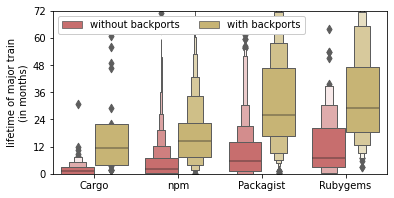

In [96]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='time',
    hue='backport',
    data=(
        temp
        .replace({'backport': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2, loc='upper left')
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=12))

ax.set(
    xlabel='',
    ylabel='lifetime of major train\n(in months)',
    ylim=(0, 72),
)

savefig(fig, 'support_time_restricted')

In [97]:
print(
    temp
    .groupby(['ecosystem', 'backport'])
    .apply(lambda d: d['time'].describe())
    .to_string()
)

time                 count       mean        std       min        25%        50%        75%         max
ecosystem backport                                                                                     
Cargo     False       73.0   2.372647   4.303699  0.000000   0.000000   1.033681   2.972519   30.963400
          True        22.0  17.966749  18.702635  1.864170   4.027419  11.327364  21.880286   60.923181
Packagist False      486.0   9.830003  12.747829  0.000000   1.105635   5.608113  14.138766   64.155585
          True       677.0  32.477064  21.643408  0.152363  16.502498  26.117598  46.694951  101.691182
Rubygems  False      113.0  13.244731  14.855622  0.000000   3.048255   7.040209  20.371415   78.986535
          True       138.0  35.231667  21.236914  2.933505  18.433919  29.217312  47.358564   92.659829
npm       False     2380.0   5.394059   8.397848  0.000000   0.237647   2.250098   6.866002   73.408870
          True      1279.0  17.559939  14.411895  0.000095   7.2

In [98]:
(
    temp
    .groupby(['ecosystem', 'backport'])
    .apply(lambda d: d['time'].describe())
    ['50%']
    .unstack()
    .assign(ratio=lambda d: d[True] / d[False])
)

backport,False,True,ratio
ecosystem,,,
Cargo,1.033681,11.327364,10.958275
Packagist,5.608113,26.117598,4.657110
Rubygems,7.040209,29.217312,4.150063
npm,2.250098,14.457792,6.425406


In [99]:
(
    temp
    .groupby(['ecosystem', 'package', 'backport'])
    .agg({'time': 'mean'})
    .unstack()
    ['time']
    .assign(ratio=lambda d: d[True] / d[False])
    [lambda d: d['ratio'] != np.inf]
    .groupby(['ecosystem'])
    .agg(mean=('ratio', 'mean'), median=('ratio', 'median'))
)

,mean,median
ecosystem,,
Cargo,3.513331,2.237869
Packagist,2893.617081,2.356917
Rubygems,9.427758,2.122047
npm,1148.183187,2.107005


In [100]:
for ecosystem in ECOSYSTEMS:
    A = temp[lambda d: (d['ecosystem'] == ecosystem) & d['backport']].time
    B = temp[lambda d: (d['ecosystem'] == ecosystem) & ~d['backport']].time
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.00000; d=0.783 (large)
npm        with vs. without: p=0.00000; d=0.666 (large)
Packagist  with vs. without: p=0.00000; d=0.712 (large)
Rubygems   with vs. without: p=0.00000; d=0.660 (large)


### In terms of versions

We only consider packages with backports for the above reasons. 

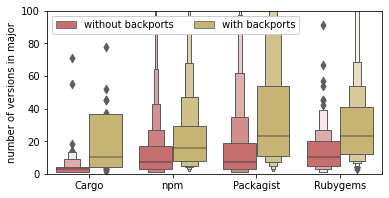

In [101]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='versions',
    hue='backport',
    data=(
        temp
        .replace({'backport': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2, loc='upper left')

ax.set(
    xlabel='',
    ylabel='number of versions in major',
    ylim=(0, 100),
)

savefig(fig, 'support_versions')

In [102]:
(
    temp
    .groupby(['ecosystem', 'backport'])
    .apply(lambda d: d['versions'].describe())
)

versions             count       mean         std  min   25%   50%   75%  \
ecosystem backport                                                         
Cargo     False       73.0   5.493151   10.463061  1.0   1.0   3.0   4.0   
          True        22.0  24.272727   29.801217  2.0   4.0  10.0  36.5   
Packagist False      486.0  17.761317   28.592635  1.0   3.0   7.0  19.0   
          True       677.0  46.345643   73.755745  2.0  11.0  23.0  54.0   
Rubygems  False      113.0  14.902655   14.536877  1.0   5.0  10.0  20.0   
          True       138.0  46.181159  119.320597  3.0  12.0  23.0  41.0   
npm       False     2380.0  15.798319   90.251401  1.0   3.0   7.0  17.0   
          True      1279.0  27.708366   59.169607  2.0   8.0  16.0  29.5   

versions               max  
ecosystem backport          
Cargo     False       71.0  
          True       119.0  
Packagist False      226.0  
          True      1338.0  
Rubygems  False       91.0  
          True       844.0  
npm       False     4280.0  
          True      1345.0

In [103]:
for ecosystem in ECOSYSTEMS:
    A = temp[lambda d: (d['ecosystem'] == ecosystem) & d['backport']].versions
    B = temp[lambda d: (d['ecosystem'] == ecosystem) & ~d['backport']].versions
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.00001; d=0.609 (large)
npm        with vs. without: p=0.00000; d=0.411 (medium)
Packagist  with vs. without: p=0.00000; d=0.501 (large)
Rubygems   with vs. without: p=0.00000; d=0.476 (large)
